## DSGE w. Feedback - Numerical Simulations

### Imports

In [30]:
%matplotlib notebook
%matplotlib inline

In [31]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [45]:
import steadystate
import model

## Simulation mechanics

In [6]:
def step(t: float, x: np.ndarray, p: dict, err:float):
    """Iteration of one step in the simulation
    
    Parameters
    ----------
    t : float
        Current timestep t
    x : np.ndarray
        state variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, g_, s_, news_, inc_, xiz_, xin_ = x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
    
    # Observe "State of economy"
    g = g_
    signal = np.tanh(p['s_theta'] * (s_ - news_))
    s = 0.5 * ((p['s_max'] - p['s_min']) * signal + p['s_max'] + p['s_min'])

    # Determine Consumption
    c = model.bisection(z, g, k_, p)
    
    # Working hours via market clearing
    n = ((c / z) ** (-1 * p['mu']) - p['alpha'] * k_ ** (-1 * p['mu']))
    n = (n / (1 - p['alpha'])) ** (-1 / p['mu'])
    
    # Firm observes desired working hours, sets the wage accordingly
    rho = -1 * p['mu']
    temp = (p['alpha'] * k_ ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (rho - 1))
    
    # Income
    income = w * n + (b_  + q_ * k_) / (1 + p['inflation'])
    
    # Investment & Bonds
    investment = income * (1 - g)
    b = (1 + p['interest']) * s * investment
    
    # Capital & Risky return
    k = (1 - p['depreciation']) * k_ + investment * (1 - s)
    q = p['alpha'] * z * temp * (k ** (rho - 1))
    
    # Signals to the household investor
    info_c = c / c_ - 1
    info_r = (q - p['interest']) / (q + p['interest'])
    news = p['s0'] * info_c + (1 - p['s0']) * info_r
    
    return z, c, n, b, w, k, q, g, s, news, income, xiz, xin

# TO CHANGE THE STEP DO NOT CHANGE THE RETURN VARIABLES

----
## Interactive Analysis

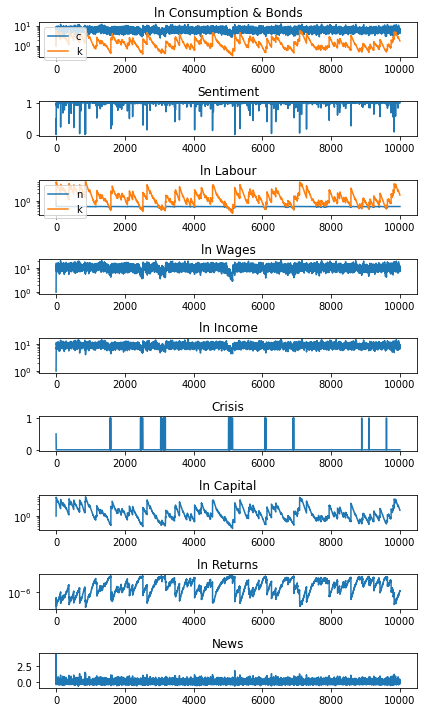

In [58]:
params = {'etaZ': 0.2, 'sigmaZ': 0.2, 'zbar': 10.0,
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.01, 
          's_min': 1e-4, 's_max': 1-1e-4,'s_theta':5.0, 's0':0.99,
          'gamma': 1.0, 'alpha': 0.33, 'mu': 12.32}

start = dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.0, g=0.7, s=0.5, income=1, news=1, xiz=0, xin=0)
start = np.array([v for _,v in start.items()])

T = 10000
np.random.seed(40)
view = (0,T)

df = model.simulate(start, params, t_end=T)

df.loc[:, 'crisis'] = 0.5 * (1.0 + np.sign(df.n - df.k))
df.loc[:, 'inv'] = 100 * (1-df.loc[:,'g'])
df.loc[:,'bc'] = df.b / df.c
df.loc[:,'utility'] = np.log(df.c) - params['gamma'] * (df.n ** 2)

df = df.iloc[view[0]:view[1],:]

graphs = {
        'ln Consumption & Bonds' : [df.loc[:,['c','k']], True],
        'Sentiment' : [df.s, False],
        'ln Labour' : [df.loc[:,['n','k']], True],
        'ln Wages' : [df.w, True],
        'ln Income' : [df.income, True],
        'Crisis' : [df.crisis, False],
        'ln Capital' : [df.loc[:,['k']], True],
        'ln Returns' : [df.q, True],
        'News' : [df.news, False],
    }


axs = steadystate.simulation_graph(graphs, size = (6, 10))
#plt.show()
#plt.savefig('/Users/fedemoro/Desktop/test.jpg', format = 'jpg', dpi = 300)

-----
# Steady State Effects of Parameter variations

In [41]:
import steadystate

In [42]:
kwargs = dict(gs_num=10, T=2e3, err=1e-4, 
              macro_vars=['c', 'n', 'b', 'k', 'q', 'w', 'utility'],
              params={'etaZ': 0.2, 'sigmaZ': 0.0, 'zbar': 1.0, 'sigmaN': 0.2, 
                      'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.04, 
                      'g_min': 0.9, 'g_max': 1-1e-4, 's_min': 0.5, 's_max': 1, 
                      'n_cons': 10, 'n_theta': 1, 'n_persistence': 0.9, 
                      'gamma': 1.0, 'alpha': 0.33, 'mu': 0.32}, 
              start_dict=dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.0, g=0.7, s=0.5, income=1, news=1, xiz=0, xin=0))

In [43]:
ss_mu = steadystate.sim_param_effect('mu', [1e-2, 1, 5], **kwargs)

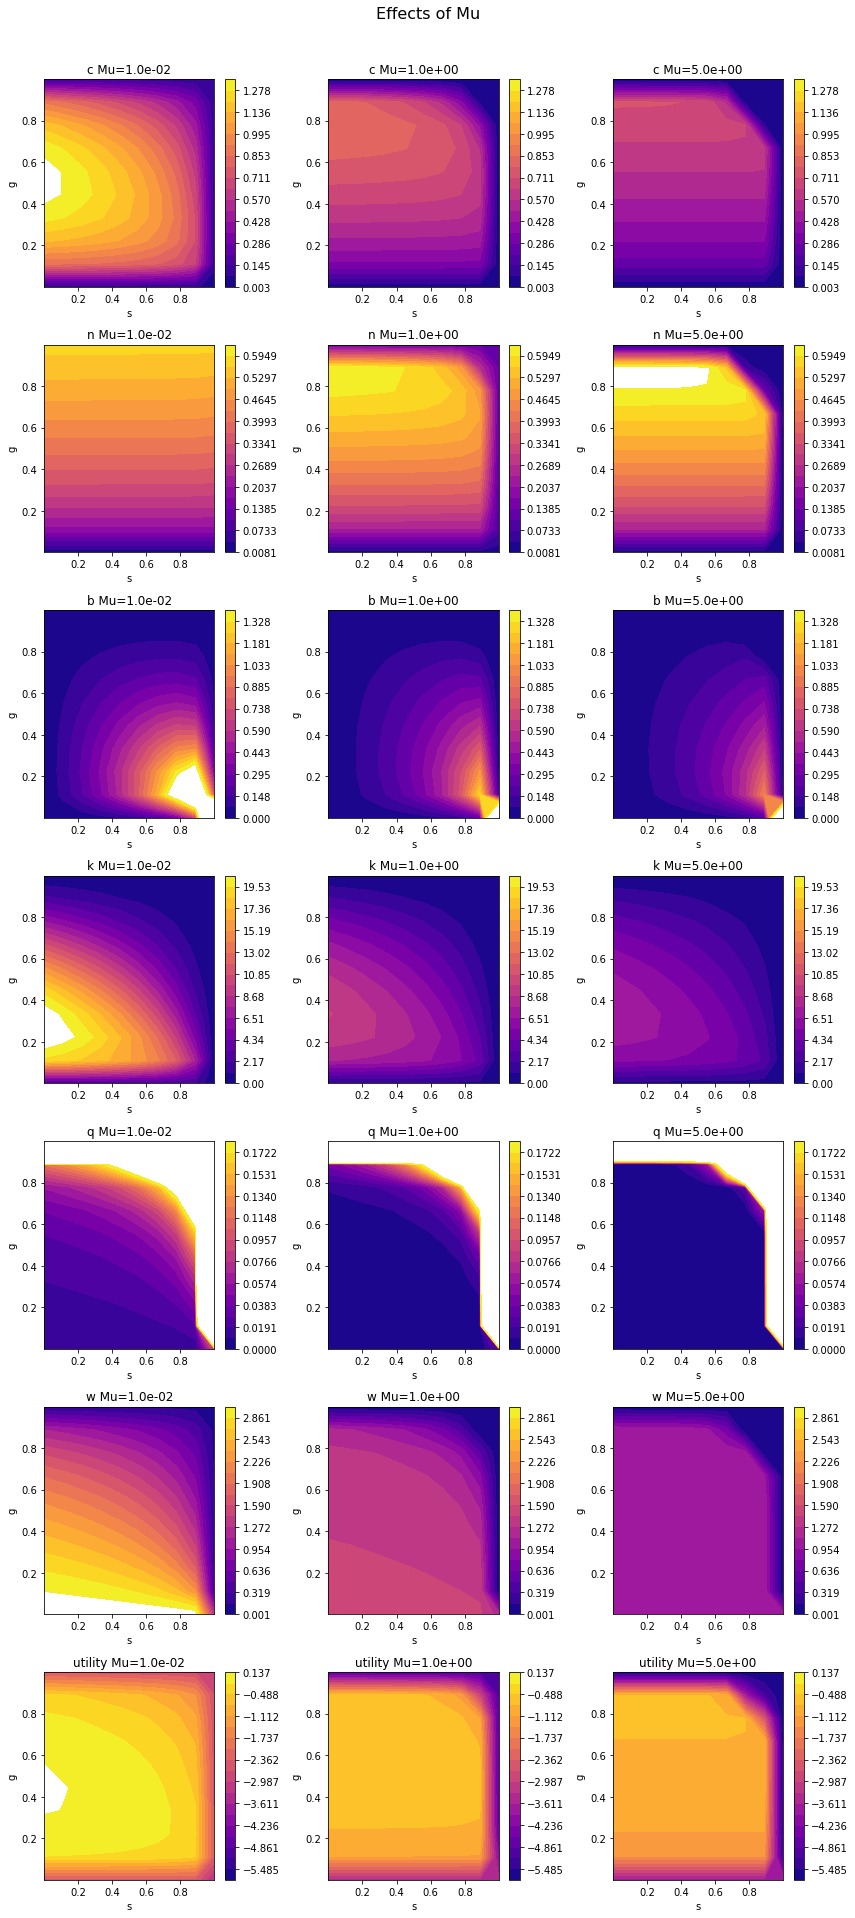

In [44]:
steadystate.plot_steady_state_effects(ss_mu, 'Mu', save='fig_steady_state_effects_rho.pdf', 
                                      sup_tit='Effects of Mu', n_lin = 20, 
                                      top_cutoff=0.9, q_cutoff=0.75, cmap = 'plasma')

### Variations in Interest

In [ ]:
gs_num = 20
ss_r = sim_param_effect('interest', [1e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1], gs_num, T, err, macro_vars, params)
plot_steady_state_effects(ss_r, save='fig_steady_state_effects_r.pdf', sup_tit='Effects of the Interest Rate')

### Variations in Alpha

In [ ]:
gs_num = 20
ss_a = sim_param_effect('alpha', [1e-2, 1e-1, 2e-1, 5e-1, 7e-1], gs_num, T, err, macro_vars, params)
plot_steady_state_effects(ss_a, save='fig_steady_state_effects_alpha.pdf', sup_tit='Effects of Alpha')